In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.preprocessing import *
from util import *

import lightgbm as lgb
from Models import lgbModel
print(lgb.__version__)

import json
import joblib



4.5.0


In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = compute_features(df.drop('mortality',axis=1))
print(x.shape)
y = df.mortality.values

base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]

with open('lightgbm.json','r') as f:
    lightgbm_param = json.load(f)

(5647, 66)


In [4]:
lightgbm_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(lightgbm_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(lightgbm_param['n_neighbors']))),
]
lightgbm_pipeline = Pipeline(lightgbm_pipeline)
lightgbm_x = lightgbm_pipeline.fit_transform(x)
fnames = x.columns.to_list()+['is_outlier']
lightgbm_x = pd.DataFrame(lightgbm_x, columns=fnames)

In [5]:
# Define the F1 Score metric
def f1_metric(y_true, y_pred):
  y_pred = (y_pred>=0.5).astype(int)
  f1 = f1_score(y_true, y_pred)
  return "f1", f1, True

params = {
    "objective": "binary",
    "metric": None,
    "verbosity": -1,
    "boosting_type": "dart",
    "is_unbalance": True,
    "num_boost_round": 1000,
    "learning_rate" : 0.03,

    "max_depth" : int(lightgbm_param['max_depth']),
    "num_leaves" : int(lightgbm_param['num_leaves']),
    "min_data_in_leaf": int(lightgbm_param['min_data_in_leaf']),
    "bagging_fraction": lightgbm_param['bagging_fraction'],
    "feature_fraction": lightgbm_param['feature_fraction'],
    "lambda_l1": lightgbm_param['lambda_l1'],
    "lambda_l2": lightgbm_param['lambda_l2'],
    "min_split_gain": lightgbm_param['min_split_gain'],
    "max_bin": int(lightgbm_param['max_bin']),
    # dart param
    "drop_rate": lightgbm_param['drop_rate'],
    "max_drop": int(lightgbm_param['max_drop'])
}



In [6]:
eval_result = {}
record_evaluation_callback = lgb.callback.record_evaluation(eval_result =eval_result )

model = lgbModel(eval_metric=f1_metric, **params)
model.fit(
    lightgbm_x, y,
    eval_set=[(lightgbm_x, y)],
    callbacks=[record_evaluation_callback],
)

c:\Users\johne\anaconda3\envs\ml\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


lgbModel(eval_metric=<function f1_metric at 0x00000220340D5480>)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='f1'>

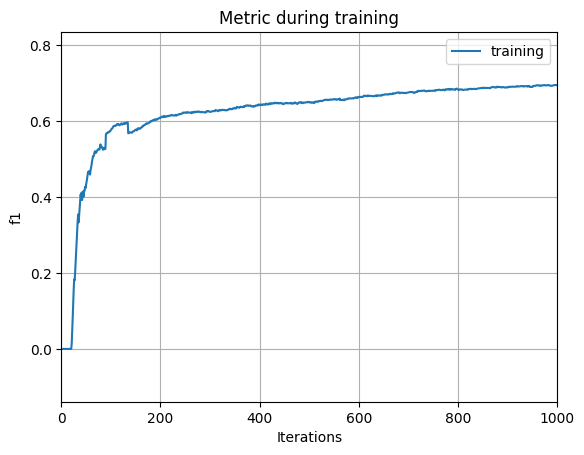

In [7]:
lgb.plot_metric(eval_result,metric='f1')

## Saving the model

In [8]:
joblib.dump(lightgbm_pipeline, 'lightgbm_pipeline.pkl')
model.model.booster_.save_model('lightgbm.txt')

## Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

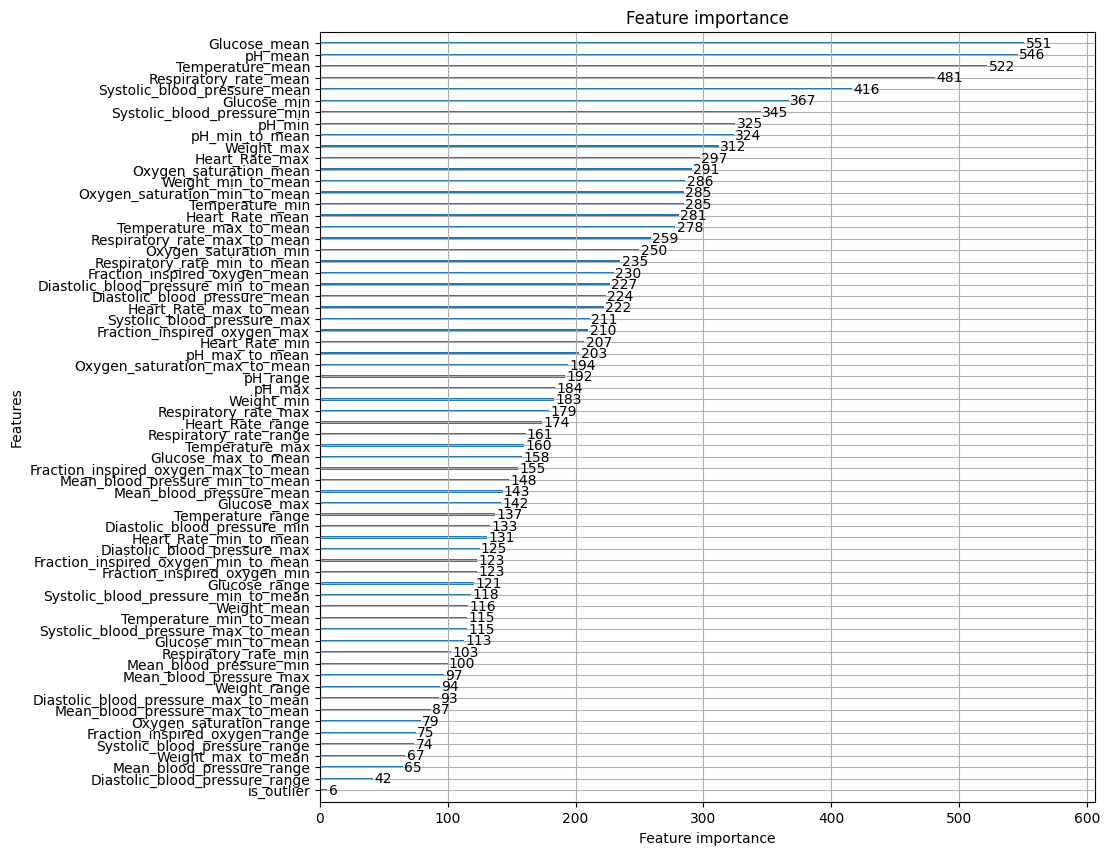

In [9]:
model.model.booster_.feature_importance()

lgb.plot_importance(model.model.booster_,figsize=(10,10))

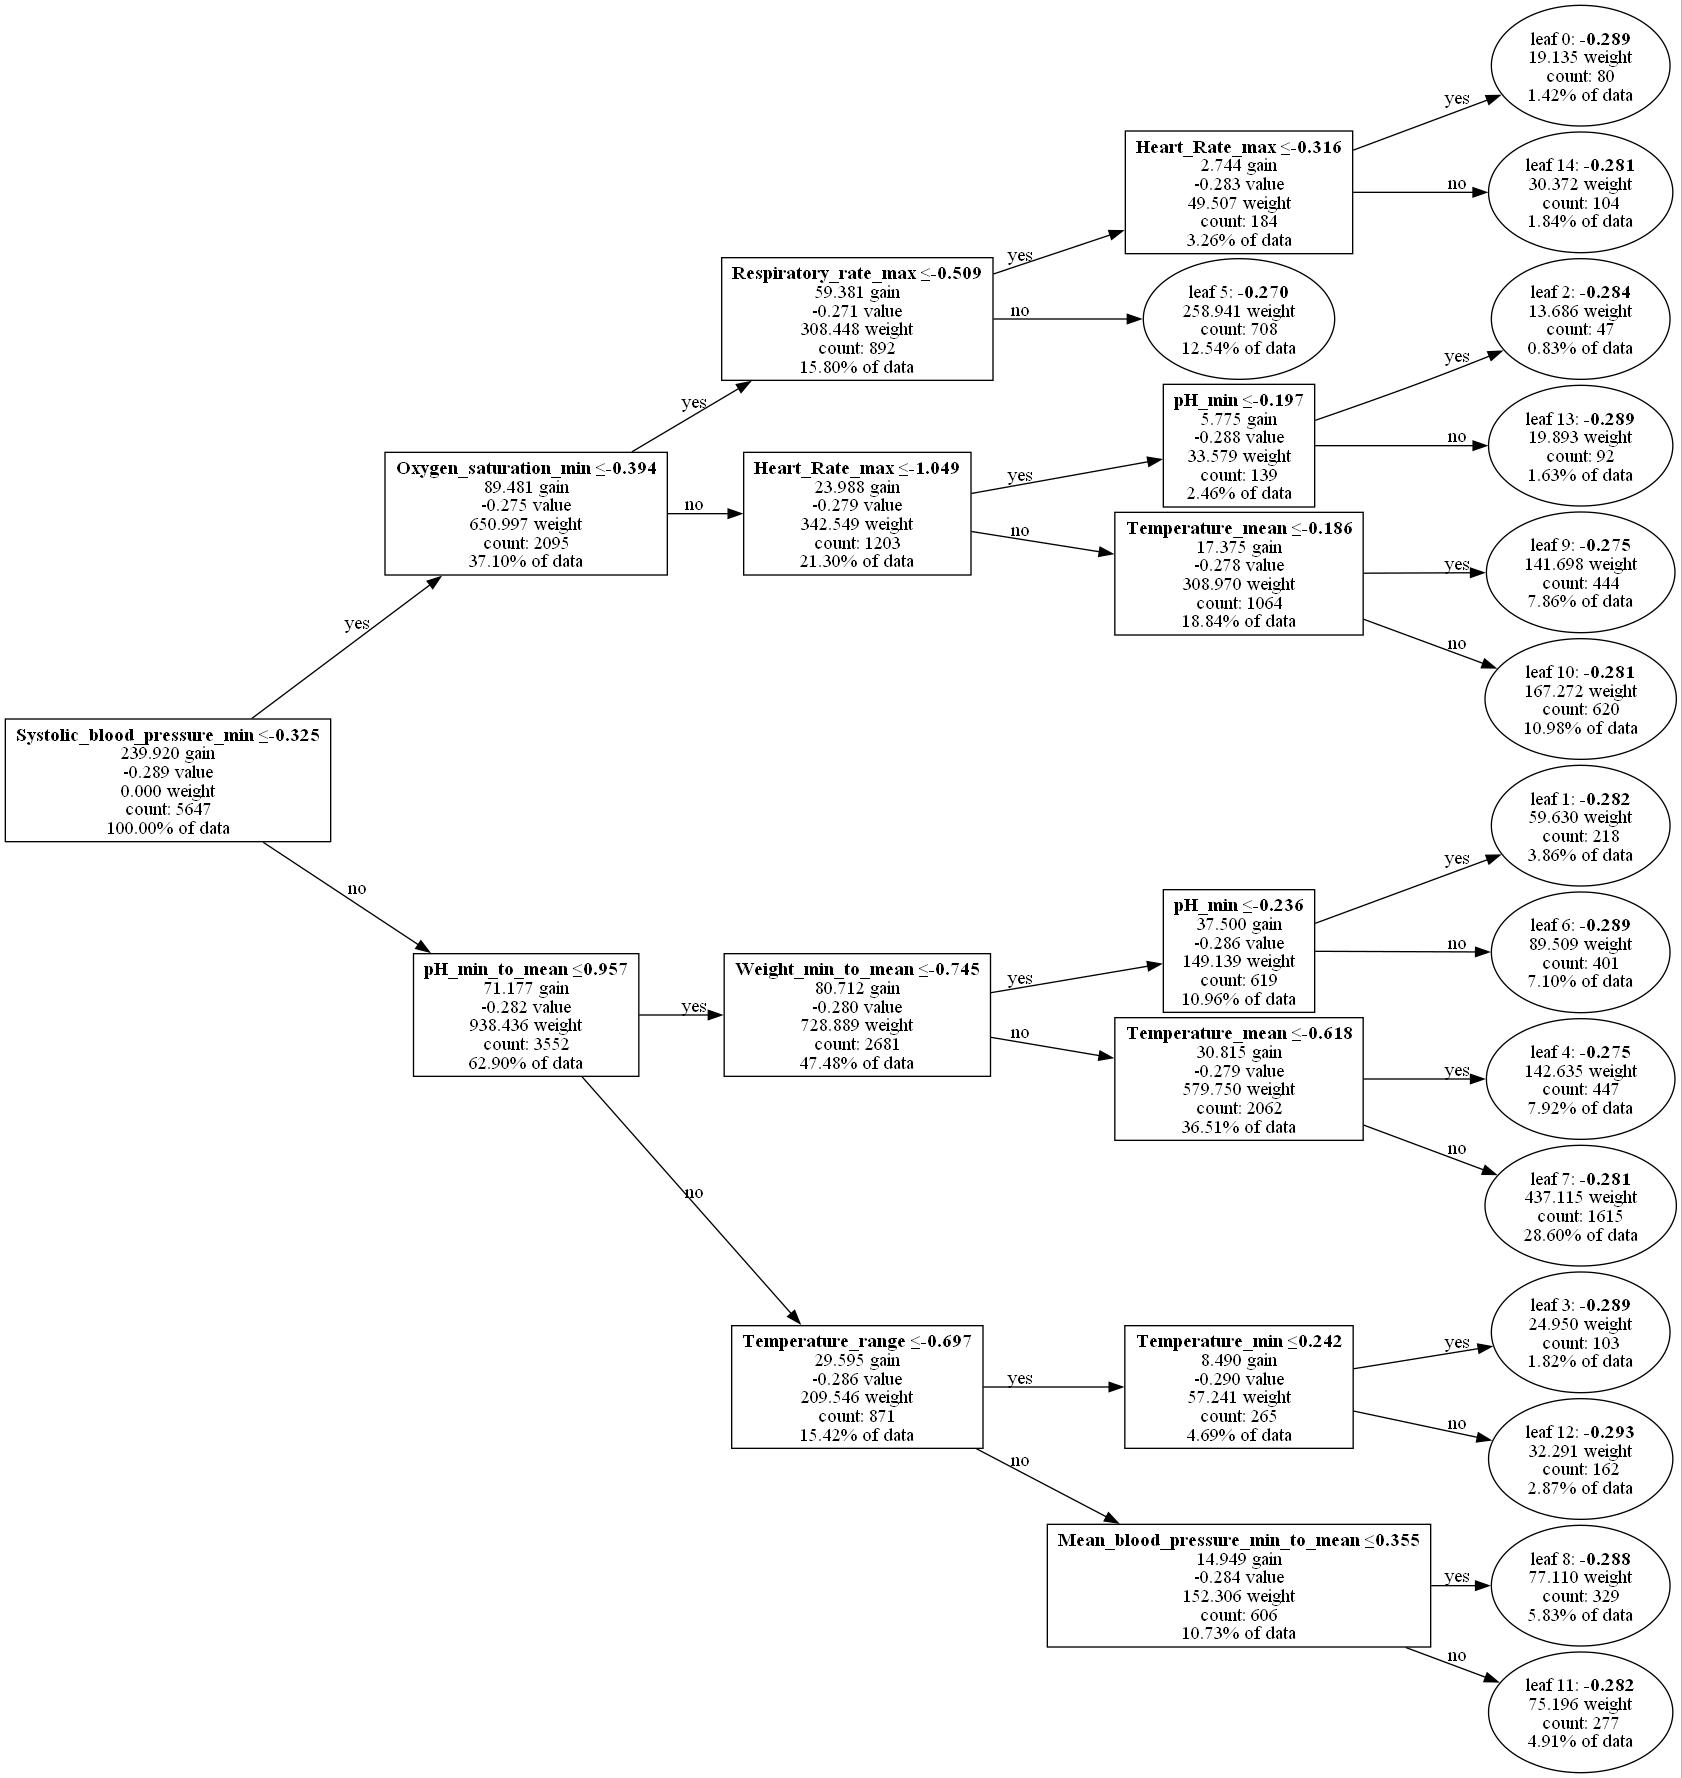

In [10]:
from PIL import Image

graph = lgb.create_tree_digraph(model.model.booster_, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count','internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])

image = graph.render('lightgbm/lightgbm_plot_tree', format='jpg')

image = Image.open("lightgbm/lightgbm_plot_tree.jpg")
image
